In [1]:
%matplotlib notebook

Plot traces and boxplots similar to Figure 1

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import matplotlib.pyplot as plt
from pathlib import Path
from natsort import natsorted
import numpy as np
import pandas as pd
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from scipy import stats
import statsmodels.api as sm
from scipy.signal import savgol_filter
import matplotlib.ticker as plticker


# to import package in parent folder first add the parent folder to path
import sys
import os
packages_path = Path(os.path.dirname(os.path.realpath('__file__'))).parent
sys.path.insert(0, str(packages_path))

import shared_func

In [3]:
home_path = os.getcwd()

filepath = Path(home_path, 'Fig4_data')
savepath = Path(home_path, 'plots')
stat_savepath = Path(home_path, 'stats')

Path(savepath).mkdir(parents=True, exist_ok=True) 
Path(stat_savepath).mkdir(parents=True, exist_ok=True)

In [4]:
filename = 'Fig4G_noChrimson'

data = np.load(Path(filepath, filename + '.npy'))
adult=True
# and also read the metadata to have everything in one place
with open(Path(filepath, filename + '.txt')) as f:
    metadata = f.read()
    print(metadata)
# Aquisition rate on the Bergamo II scope
aq_rate = 1/0.140757247 # copy paste from csv file, time for each frame

This numpy array contains the data to create Figure 3G 
which shows response of control animals without UAS-Chrimson
at 1151uW/mm2 with 660nm stimulation light.

Output data is organized the following way:

1st dimension is 210. These are the datapoints 

2nd dimension is 8. These are: Time, Stim, df/f1, df/f2, df/f3, df/f4, df/f5, df/f6. 
Each df/f is a repeat on the same animal 

3rd dimension is 6, one for each animal 

4th dimension is 1.

5th dimension is 1.


<IPython.core.display.Javascript object>


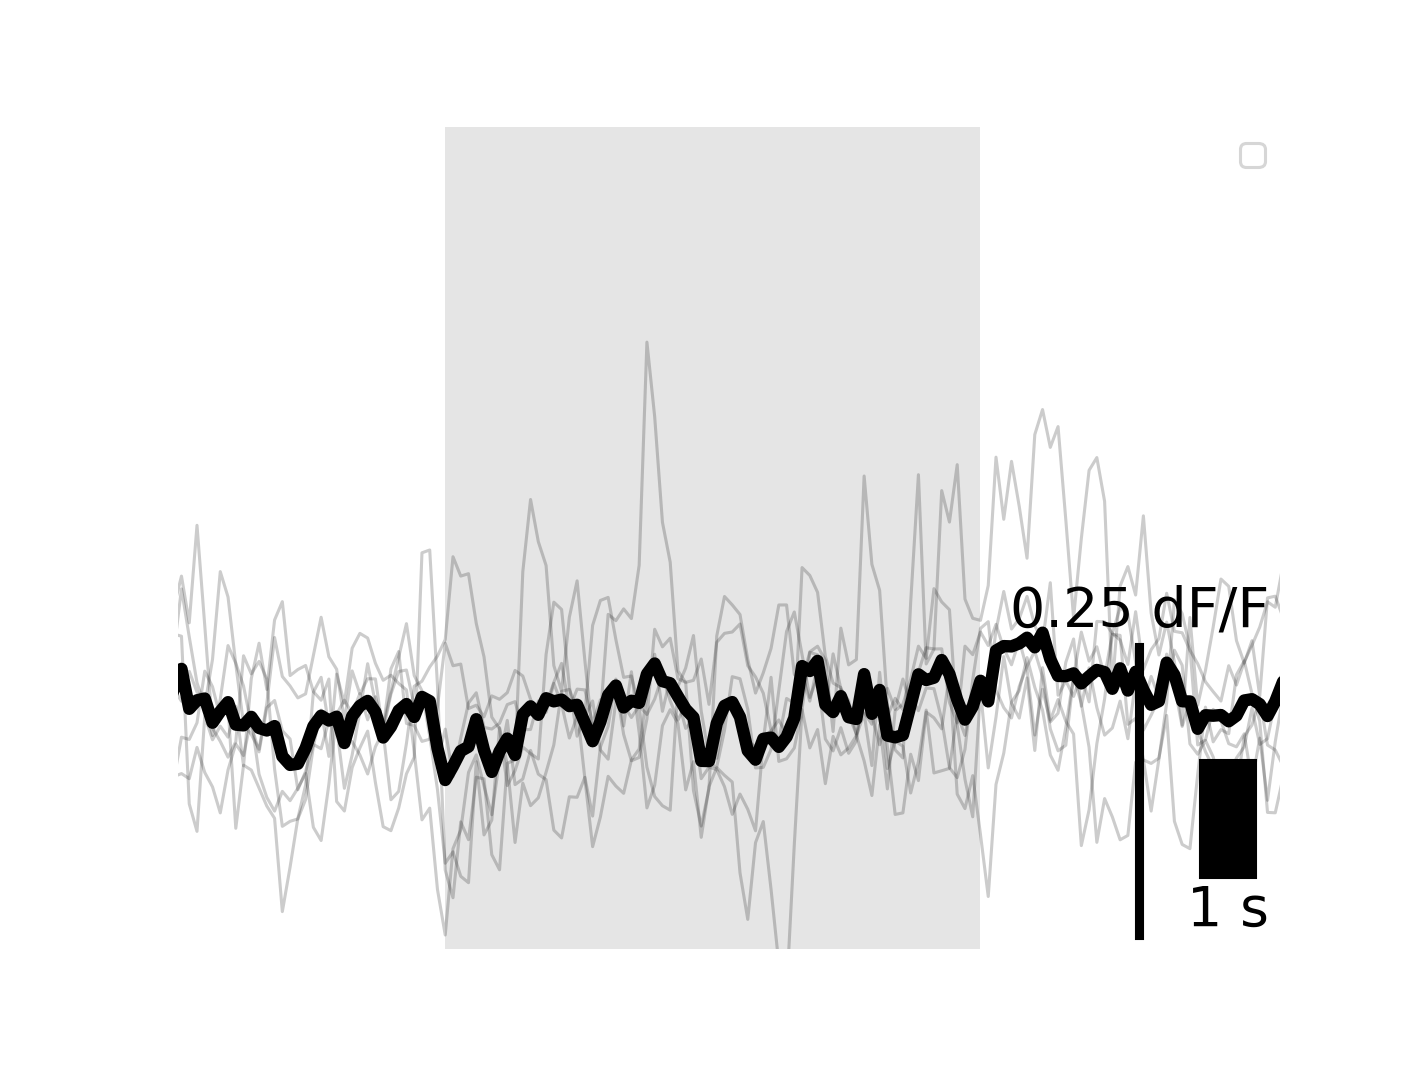

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [5]:
# Define color used for this plot
colors = ['black',]

# Prepare the raw data for plotting
median_per_animal = shared_func.median_per_animal_func(aq_rate=aq_rate, data=data)

# Then, plot the trace plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Here we have only one group
group = 0

for stim_intensity in range(data.shape[3]):

    ax.plot(data[:,0,0,stim_intensity,group], median_per_animal[:,:,stim_intensity,group], lw=1, zorder=1, 
            color=colors[stim_intensity], alpha=0.2)
    # and plot the mean of the median in bold
    ax.plot(data[:,0,0,stim_intensity,group], np.mean(median_per_animal[:,:,stim_intensity,group], axis=1), 
            lw=4, zorder=1, color=colors[stim_intensity])

# Plot stimulus
start_stim = np.where(data[:, 1, 0, stim_intensity, 0] > 0.1)[0][0]
stop_stim = np.where(data[:, 1, 0, stim_intensity, 0] > 0.1)[0][-1]
ax.axvspan(data[start_stim, 0, 0, stim_intensity, 0],
           data[stop_stim, 0, 0, stim_intensity, 0],
           lw=0, zorder=0,
           color='k',
           alpha=0.1)
ax.set_xlim(5,25)
ax.set_ylim(-0.2,0.5)

fontprops = fm.FontProperties(size=18)
scalebar_time = AnchoredSizeBar(ax.transData,
                                1, '1 s', 'lower right',
                                pad=0.1,
                                color='black',
                                frameon=False,
                                size_vertical=0.1,
                                fontproperties=fontprops)

scalebar_df = AnchoredSizeBar(ax.transData,
                              0.1, '0.25 dF/F', 'lower right',
                              pad=0.1,
                              color='black',
                              frameon=False,
                              size_vertical=0.25,
                              fontproperties=fontprops,
                              label_top=True)

ax.add_artist(scalebar_time)
ax.add_artist(scalebar_df)
ax.legend()
ax.axis('off')

# This is not shown so no need to save the figure
savename = 'Fig4G.svg'
fig.savefig(Path(savepath, savename),
           transparent=True)

In [6]:
# Median values before and during
# For readability explicitly state what is being taken
before_start_index = int(round(start_stim-aq_rate*9)) # one second before start
before_end_index = start_stim

during_start_index = int(round(start_stim)) # From beginning of stimulus...
during_end_index = int(round(stop_stim)) # ...until the end of the stimulus

median_before_stim = np.median(median_per_animal[before_start_index:start_stim, :, :],axis=0)
median_during_stim = np.median(median_per_animal[during_start_index:during_end_index, :, :],axis=0)

<IPython.core.display.Javascript object>


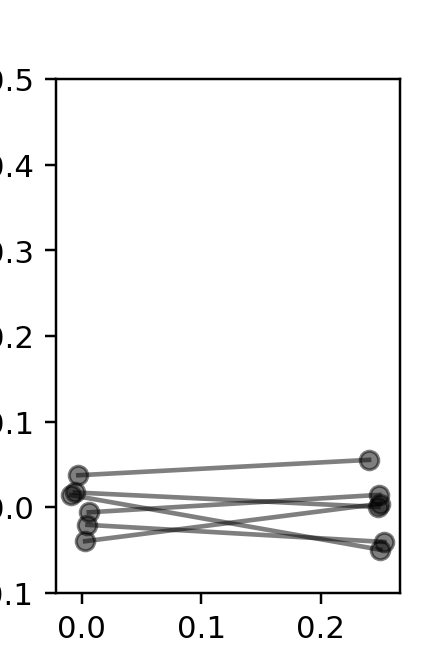

In [7]:
fig = plt.figure(figsize=(2,3))
ax = fig.add_subplot(111)

shared_func.plot_connected_scatterplot(ax, median_before_stim, median_during_stim, 
                                       light_intensity=stim_intensity, 
                                       color=colors[0], start_x_position=0, group=0)

ax.set_ylim(-0.1,0.5)
savename = 'Fig4G.svg'
fig.savefig(Path(savepath, savename),
            transparent=True)

In [8]:
p_values=[]

# median_before_stim.shape
# (6, 3, 1) # Animal, light intensity, group
shared_func.pairwise_t_tests(median_during_stim[:,0,0], median_before_stim[:,0,0], p_values,
                            non_parametric=False)

print('Holms-Bonferroni correction:')
shared_func.holms_bonferroni_correction(p_values)

lilliefors: 0.5761576578952206
T-Test
TtestResult(statistic=-0.1979083586118283, pvalue=0.8509113906498313, df=5)


Holms-Bonferroni correction:
NOT DIFFERENT!
current p: 0.8509113906498313, current alpha: 0.05


## Export stats

In [9]:
data = [[median_during_stim[:,0,0], median_before_stim[:,0,0]]
       ]

label_list_stat_export = [['During, 1151uW/mm2', 'Before, 1151uW/mm2']]
savename = 'Fig_4G'

shared_func.export_pairwise_dependent_test(data, label_list_stat_export,
                                           savepath=stat_savepath, savename=savename,
                                           parametric=True)

                Group  n      mean    median       STD       SEM  \
0  During, 1151uW/mm2  6 -0.002824  0.002047  0.035032  0.014302   
1  Before, 1151uW/mm2  6  0.000277  0.003951  0.025591  0.010447   

                              95% CI on the mean  DOF statistical test  \
0   (-0.043097381286385884, 0.03744906634886764)  5.0       T-test rel   
1  (-0.029142076180323283, 0.029696737542740343)  NaN              NaN   

   t-statistic   p-value significant  
0    -0.197908  0.850911          NO  
1          NaN       NaN         NaN  
